# Accessing Census and ACS Data in Python

By: Steven Chao & Michael Mann

---------------
```{admonition} Learning Objectives
* Import dataframes into Python for analysis
* Perform basic dataframe column operations
* Merge dataframes using a unique key
* Group attributes based on a similar attribute
* Dissolve vector geometries based on attribute values
```
```{admonition} Review
* [Data Structures](c_features.md)
* [Vector Data ](c_vectors.md)
```
--------------

## Introduction

This chapter will show you how to access US  Decennial Census and American Community Survey Data (ACS). We will use these basic operations in order to calculate and map poverty rates in the Commonwealth of Virginia. We will pull data from the US Census Bureau's [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs) 2019 (see [this page](https://www.census.gov/data/developers/data-sets/acs-5year.html) for the data).

For a detailed list of variable explainations, visit [https://censusreporter.org/topics/table-codes/](https://censusreporter.org/topics/table-codes/).

In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pytidycensus as tc
import os

## Accessing Data

### Import census data

Let's begin by accessing and importing census data. Importing census data into Python using pytidycensus requires a Census API key. A key can be obtained from [Census API Key](http://api.census.gov/data/key_signup.html).  **It will provide you with a unique 40 digit text string. Please keep track of this number. Store it in a safe place.**

In [2]:
# Set API key for pytidycensus
tc.set_census_api_key("CENSUS API KEY HERE")

Census API key has been set for this session.


In [3]:
# ignore this, I am just reading in my api key privately
import yaml
import os

def get_credentials():
    try:
        with open('credentials.yaml') as f:
            return yaml.safe_load(f)
    except FileNotFoundError:
        return {}

creds = get_credentials()
api_key = creds.get('census_api_key') or os.environ.get('CENSUS_API_KEY')
tc.set_census_api_key(api_key)

Census API key has been set for this session.


With the Census API key set, we will access the census data at the tract level for the Commonwealth of Virginia from the 2019 ACS, specifically the `ratio of income to poverty in the past 12 months` (`C17002_001E`, total; `C17002_002E`, < 0.50; and `C17002_003E`, 0.50 - 0.99) variables and the `total population` (`B01003_001E`) variable. For more information on why these variables are used, refer to the US Census Bureau's [article on how the Census Bureau measures poverty](https://www.census.gov/topics/income-poverty/poverty/guidance/poverty-measures.html) and the [list of variables found in ACS](https://api.census.gov/data/2019/acs/acs5/variables.html).

The `pytidycensus` package provides us with clean, convenient methods to obtain data for a wide variety of geographies. We can simply specify the state name (e.g., "Virginia" or "VA") without needing to look up FIPS codes.

In [4]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html
va_census = tc.get_acs(
    geography="tract",
    variables=["C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"],
    state="VA",
    year=2019,
    output="wide"
)

Getting data from the 2015-2019 5-year ACS


The `pytidycensus` package returns data as pandas DataFrames by default, so our data is already in the correct format.

In [5]:
# Show the dataframe (already a pandas DataFrame)
print(va_census.head(2))
print('Shape: ', va_census.shape)

   C17002_001E  C17002_002E  C17002_003E  B01003_001E state county   tract  \
0         4804          197          146         4863    51    065  020200   
1         4578           58           30         4578    51    059  460702   

         GEOID  C17002_001_moe  C17002_002_moe  C17002_003_moe B01003_001_moe  
0  51065020200           387.0           144.0           111.0          383.0  
1  51059460702           239.0            62.0            27.0          239.0  
Shape:  (1907, 12)


By showing the dataframe, we can see that there are 1907 rows (therefore 1907 census tracts) and 8 columns.

Notice that for each variable we get two columns: one with the estimate (e.g., `C17002_001E`) and one with the margin of error (e.g., `C17002_001_moe`).  For this analysis, we will only use the estimate columns.

### Add Geographic Boundaries

Instead of manually downloading shapefiles, we can use `pytidycensus` to automatically retrieve the geographic boundaries along with our census data. Let's get the same tract-level data but this time with geometry included:

In [6]:
# Get census data with geometric boundaries included
va_tract = tc.get_acs(
    geography="tract",
    variables=["C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"],
    state="VA",
    year=2019,
    output="wide",
    geometry=True
)

# Reproject to UTM Zone 17N for better area calculations
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
va_tract = va_tract.to_crs(epsg=32617)

# Print GeoDataFrame
print(va_tract.head(2))
print('Shape: ', va_tract.shape)

# Check projection
print("\nThe projection is: {}".format(va_tract.crs))

Getting data from the 2015-2019 5-year ACS


Loading tract boundaries...


         GEOID    NAME                                           geometry  \
0  51700032132  321.32  POLYGON ((897174.191 4119897.084, 897174.811 4...   
1  51700032226  322.26  POLYGON ((893470.562 4123469.385, 893542.722 4...   

  STATEFP COUNTYFP TRACTCE  C17002_001E  C17002_002E  C17002_003E  \
0      51      700  032132         4997          208          182   
1      51      700  032226         4483          625          739   

   B01003_001E state county   tract  C17002_001_moe  C17002_002_moe  \
0         4997    51    700  032132           426.0           115.0   
1         4490    51    700  032226           453.0           463.0   

   C17002_003_moe B01003_001_moe  
0           219.0          426.0  
1           381.0          454.0  
Shape:  (1907, 17)

The projection is: epsg:32617


Perfect! With `pytidycensus`, we now have both the census data and the geographic boundaries in a single GeoDataFrame. This eliminates the need to merge separate datasets since the census data and geometry are already connected.

## Performing Dataframe Operations

Since we're using `pytidycensus`, our data already comes with all the necessary geographic identifiers and is ready for analysis. Let's clean up the data and prepare it for our poverty analysis.
 
### Aggregate tract data to county level

Next, we will group all the census tracts within the same county and aggregate the poverty and population values for those tracts within the same county. We can use the `dissolve` function in `GeoPandas`, which is the spatial version of `groupby` in `pandas`. We use `dissolve` instead of `groupby` because the former also groups and merges all the geometries (in this case, census tracts) within a given group (in this case, counties).

To control which columns are aggregated and how they are aggregated, we can use the `aggfunc` parameter. In this case, we want to sum up the poverty counts and population values for all the census tracts within each county.

In [7]:
# Extract county FIPS from GEOID (first 5 characters: state + county)
va_tract['COUNTYFP'] = va_tract['GEOID'].str[:5]

# Dissolve and group the census tracts within each county and aggregate all the values together  https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html

va_poverty_county = va_tract.dissolve(by='COUNTYFP', aggfunc={'C17002_001E': 'sum',
                                                              'C17002_002E': 'sum',
                                                              'C17002_003E': 'sum',
                                                              'B01003_001E': 'sum'})


# Show dataframe
print(va_poverty_county.head(2))
print('Shape: ', va_poverty_county.shape)

                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
51001     POLYGON ((971814.409 4160130.005, 971664.507 4...        32325   
51003     POLYGON ((722871.236 4189239.708, 722813.526 4...       100293   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
51001            2352         3789        32673  
51003            5034         4108       107405  
Shape:  (133, 5)


Notice that we got the number of rows down from 1907 to 133.

### Calculate poverty rates

We can estimate the poverty rate by dividing the sum of `C17002_002E` (ratio of income to poverty in the past 12 months, < 0.50) and `C17002_003E` (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by `B01003_001E` (total population).

Side note: Notice that `C17002_001E` (ratio of income to poverty in the past 12 months, total), which theoretically should count everyone, does not exactly match up with `B01003_001E` (total population). We'll disregard this for now since the difference is not too significant.

In [8]:
# Calculate poverty rate and store values in new column
va_poverty_county["Poverty_Rate"] = (
    (va_poverty_county["C17002_002E"] + va_poverty_county["C17002_003E"]) / 
    va_poverty_county["B01003_001E"] * 100
)

# Show dataframe
va_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
51001,"POLYGON ((971814.409 4160130.005, 971664.507 4...",32325,2352,3789,32673,18.795336
51003,"POLYGON ((722871.236 4189239.708, 722813.526 4...",100293,5034,4108,107405,8.511708


## Plotting Results

Finally, since we have the spatial component connected to our census data using `pytidycensus`, we can plot the results! The integration of geometry with census data makes mapping straightforward.

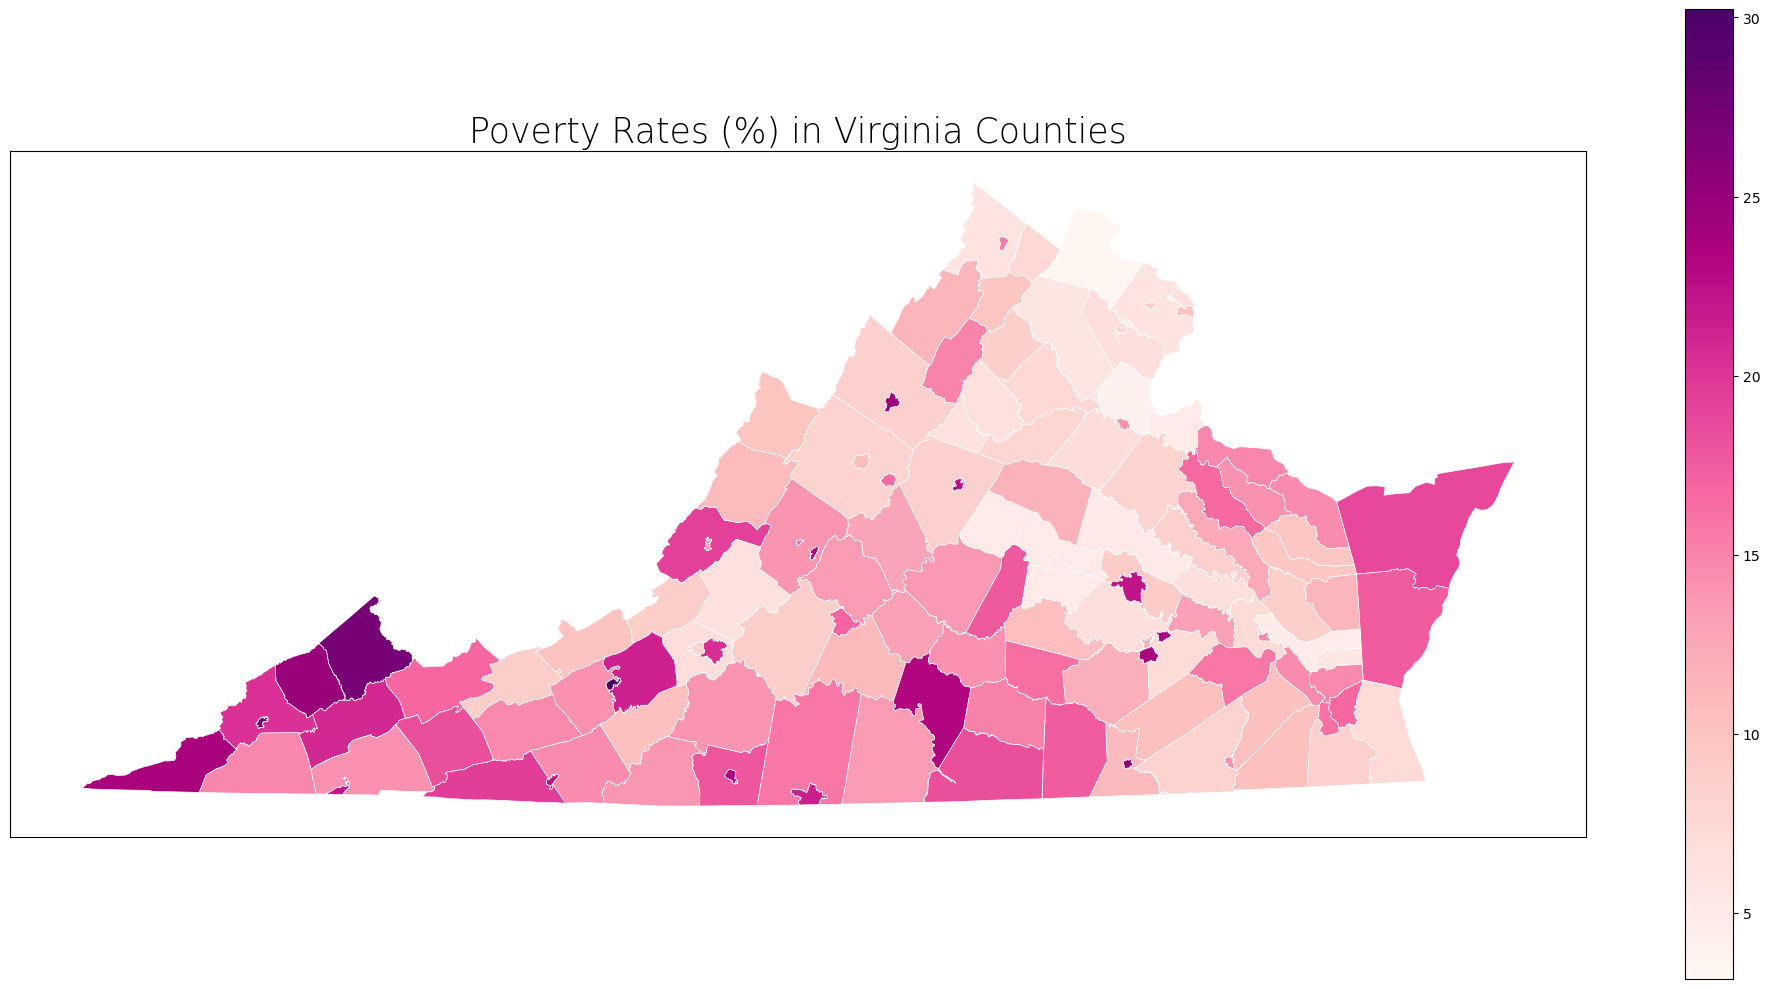

In [9]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
va_poverty_county.plot(
    column="Poverty_Rate",
    ax=ax,
    cmap="RdPu",
    legend=True,
    edgecolor='white',
    linewidth=0.5
)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Virginia Counties', 
             fontdict={'fontsize': '25', 'fontweight': '3'})

# Remove axis ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()

## Summary

This tutorial demonstrated how to use `pytidycensus` to:

1. **Easily access Census data**: Set up API key and retrieve ACS data with a simple function call
2. **Integrate spatial data**: Automatically include geometric boundaries with `geometry=True`
3. **Eliminate data merging**: Get census attributes and geography in a single step
4. **Perform spatial analysis**: Use standard pandas/geopandas operations on the integrated data
5. **Create effective visualizations**: Map results directly without complex data preparation

Key advantages of using `pytidycensus`:
- **Simplified workflow**: No need to download separate shapefiles or perform complex merges
- **Consistent data format**: Returns familiar pandas DataFrames and GeoPandas GeoDataFrames
- **Built-in geography**: TIGER/Line boundaries automatically aligned with census data
- **Flexible output**: Choose between tidy and wide formats based on analysis needs
- **Comprehensive coverage**: Support for multiple census datasets (ACS, Decennial, Population Estimates)